In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=0)

In [2]:
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
from IPython.core.debugger import set_trace

In [3]:
# %load my_train_helper.py
def get_trainable(model_params):
    return (p for p in model_params if p.requires_grad)


def get_frozen(model_params):
    return (p for p in model_params if not p.requires_grad)


def all_trainable(model_params):
    return all(p.requires_grad for p in model_params)


def all_frozen(model_params):
    return all(not p.requires_grad for p in model_params)


def freeze_all(model_params):
    for param in model_params:
        param.requires_grad = False

In [4]:
from torchvision import transforms

_image_size = 224
_mean = [0.485, 0.456, 0.406]
_std = [0.229, 0.224, 0.225]


train_trans = transforms.Compose([
    transforms.Resize(256),  # some images are pretty small
    transforms.RandomCrop(_image_size),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(.3, .3, .3),
    transforms.ToTensor(),
    transforms.Normalize(_mean, _std),
])
val_trans = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(_image_size),
    transforms.ToTensor(),
    transforms.Normalize(_mean, _std),
])

In [5]:
# %load my_datasets.py
import os
import zipfile

from torchvision.datasets.folder import ImageFolder, default_loader
from torchvision.datasets.utils import download_url, check_integrity


################################################################################
# PyTorch
class DogsCatsDataset(ImageFolder):
    """
    The 'Dogs and Cats' dataset from kaggle.

    https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/

    Args:
        root: the location where to store the dataset
        suffix: path to the train/valid/sample dataset. See folder structure.
        transform (callable, optional): A function/transform that takes in
            an PIL image and returns a transformed version.
            E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that
            takes in the target and transforms it.
        loader: A function to load an image given its path.
        download: if ``True``, download the data.


    The folder structure of the dataset is as follows::

        └── dogscats
            ├── sample
            │   ├── train
            │   │   ├── cats
            │   │   └── dogs
            │   └── valid
            │       ├── cats
            │       └── dogs
            ├── train
            │   ├── cats
            │   └── dogs
            └── valid
                ├── cats
                └── dogs

    """

    url = "http://files.fast.ai/data/dogscats.zip"
    filename = "dogscats.zip"
    checksum = "aef22ec7d472dd60e8ee79eecc19f131"

    def __init__(
        self,
        root: str,
        suffix: str,
        transform=None,
        target_transform=None,
        loader=default_loader,
        download=False,
    ):
        self.root = os.path.expanduser(root)

        if download:
            self._download()
            self._extract()

        if not self._check_integrity():
            raise RuntimeError(
                "Dataset not found or corrupted. "
                "You can use download=True to download it"
            )

        path = os.path.join(self.root, "dogscats", suffix)
        print(f"Loading data from {path}.")
        assert os.path.isdir(path), f"'{suffix}' is not valid."

        super().__init__(path, transform, target_transform, loader)

    def _download(self):
        if self._check_integrity():
            print("Dataset already downloaded and verified.")
            return

        root = self.root
        print("Downloading dataset... (this might take a while)")
        download_url(self.url, root, self.filename, self.checksum)

    def _extract(self):
        path_to_zip = os.path.join(self.root, self.filename)
        with zipfile.ZipFile(path_to_zip, "r") as zip_ref:
            zip_ref.extractall(self.root)

    def _check_integrity(self):
        path_to_zip = os.path.join(self.root, self.filename)
        return check_integrity(path_to_zip, self.checksum)

In [8]:
train_ds = DogsCatsDataset("../data/raw", "sample/train") #, transform=train_trans)
val_ds = DogsCatsDataset("../data/raw", "sample/valid")  #, transform=val_trans)

batch_size = 2
n_classes = 2

Loading data from ../data/raw/dogscats/sample/train.
Loading data from ../data/raw/dogscats/sample/valid.


In [9]:
train_ds[0]

(<PIL.Image.Image image mode=RGB size=499x375 at 0x146C1D83BFD0>, 0)

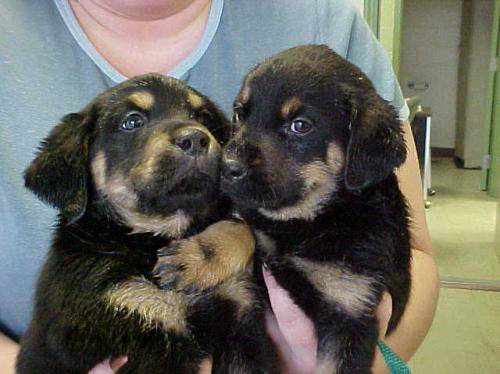

In [10]:
train_ds[14][0]

In [41]:
train_ds = DogsCatsDataset("../data/raw", "train", transform=train_trans)
val_ds = DogsCatsDataset("../data/raw", "valid", transform=val_trans)

batch_size = 128
n_classes = 2

Loading data from ../data/raw/dogscats/train.
Loading data from ../data/raw/dogscats/valid.


In [26]:
len(train_ds), len(val_ds)

(23000, 2000)

In [27]:
from torch.utils.data import DataLoader


train_dl = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
)

val_dl = DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
)

In [28]:
from torchvision import models

model = models.resnet18(pretrained=True)

In [29]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
%conda install torchsummary
import torchsummary
torchsummary.summary(model, (3, 224, 224), device="cpu")

Solving environment: failed with initial frozen solve. Retrying with flexible solve.

PackagesNotFoundError: The following packages are not available from current channels:

  - torchsummary

Current channels:

  - https://repo.anaconda.com/pkgs/main/linux-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/linux-64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.



Note: you may need to restart the kernel to use updated packages.


ModuleNotFoundError: No module named 'torchsummary'

In [31]:
# Freeze all parameters manually
for param in model.parameters():
    param.requires_grad = False

In [32]:
# Or use our convenient functions from before
freeze_all(model.parameters())
assert all_frozen(model.parameters())

In [33]:
model.fc = nn.Linear(512, n_classes)

In [34]:
assert not all_frozen(model.parameters())

In [35]:
def get_model(n_classes=2):
    model = models.resnet18(pretrained=True)
    freeze_all(model.parameters())
    model.fc = nn.Linear(512, n_classes)
    model = model.to(DEVICE)
    return model


model = get_model()

In [36]:
criterion = nn.CrossEntropyLoss()

In [37]:
optimizer = torch.optim.Adam(
    get_trainable(model.parameters()),
    lr=0.001,
    # momentum=0.9,
)

In [38]:
N_EPOCHS = 10

for epoch in range(N_EPOCHS):
    
    # Train
    model.train()  # IMPORTANT
    
    total_loss, n_correct, n_samples = 0.0, 0, 0
    for batch_i, (X, y) in enumerate(train_dl):
        X, y = X.to(DEVICE), y.to(DEVICE)
        
        optimizer.zero_grad()
        y_ = model(X)
        loss = criterion(y_, y)
        loss.backward()
        optimizer.step()
        
        # Statistics
        # print(
        #     f"Epoch {epoch+1}/{N_EPOCHS} |"
        #     f"  batch: {batch_i} |"
        #     f"  batch loss:   {loss.item():0.3f}"
        #)
        _, y_label_ = torch.max(y_, 1)
        n_correct += (y_label_ == y).sum().item()
        total_loss += loss.item() * X.shape[0]
        n_samples += X.shape[0]
    
    print(
        f"Epoch {epoch+1}/{N_EPOCHS} |"
        f"  train loss: {total_loss / n_samples:9.3f} |"
        f"  train acc:  {n_correct / n_samples * 100:9.3f}%"
    )
    
    
    # Eval
    model.eval()  # IMPORTANT
    
    total_loss, n_correct, n_samples = 0.0, 0, 0
    with torch.no_grad():  # IMPORTANT
        for X, y in val_dl:
            X, y = X.to(DEVICE), y.to(DEVICE)
                    
            y_ = model(X)
        
            # Statistics
            _, y_label_ = torch.max(y_, 1)
            n_correct += (y_label_ == y).sum().item()
            loss = criterion(y_, y)
            total_loss += loss.item() * X.shape[0]
            n_samples += X.shape[0]

    
    print(
        f"Epoch {epoch+1}/{N_EPOCHS} |"
        f"  valid loss: {total_loss / n_samples:9.3f} |"
        f"  valid acc:  {n_correct / n_samples * 100:9.3f}%"
    )

Epoch 1/10 |  train loss:     0.146 |  train acc:     94.796%
Epoch 1/10 |  valid loss:     0.068 |  valid acc:     97.600%
Epoch 2/10 |  train loss:     0.084 |  train acc:     96.774%
Epoch 2/10 |  valid loss:     0.054 |  valid acc:     97.950%
Epoch 3/10 |  train loss:     0.071 |  train acc:     97.339%
Epoch 3/10 |  valid loss:     0.052 |  valid acc:     97.950%
Epoch 4/10 |  train loss:     0.069 |  train acc:     97.387%
Epoch 4/10 |  valid loss:     0.047 |  valid acc:     98.050%
Epoch 5/10 |  train loss:     0.066 |  train acc:     97.387%
Epoch 5/10 |  valid loss:     0.045 |  valid acc:     98.200%
Epoch 6/10 |  train loss:     0.067 |  train acc:     97.361%
Epoch 6/10 |  valid loss:     0.044 |  valid acc:     98.300%
Epoch 7/10 |  train loss:     0.063 |  train acc:     97.470%
Epoch 7/10 |  valid loss:     0.051 |  valid acc:     97.600%
Epoch 8/10 |  train loss:     0.066 |  train acc:     97.257%
Epoch 8/10 |  valid loss:     0.043 |  valid acc:     98.350%
Epoch 9/

In [39]:
train_ds[14][0]

tensor([[[ 2.1119,  2.1119,  2.1119,  ...,  2.1975,  2.1975,  2.1804],
         [ 2.1119,  2.1119,  2.1119,  ...,  2.1975,  2.1975,  2.1804],
         [ 2.1119,  2.1119,  2.1119,  ...,  2.1975,  2.1975,  2.1804],
         ...,
         [-0.4226, -0.4054, -0.3027,  ...,  1.1015,  1.1529,  1.1529],
         [-0.4397, -0.4226, -0.3027,  ...,  1.0673,  1.0502,  1.0673],
         [-0.4397, -0.4226, -0.3541,  ...,  1.0331,  1.0331,  1.0502]],

        [[ 2.0784,  2.0784,  2.0784,  ...,  2.1310,  2.1310,  2.1134],
         [ 2.0784,  2.0784,  2.0784,  ...,  2.1310,  2.1310,  2.1134],
         [ 2.0784,  2.0784,  2.0784,  ...,  2.1310,  2.1310,  2.1134],
         ...,
         [-1.0028, -0.9503, -0.8452,  ...,  0.6078,  0.6429,  0.6429],
         [-1.0378, -0.9853, -0.8452,  ...,  0.5378,  0.4853,  0.5553],
         [-1.0728, -1.0028, -0.8978,  ...,  0.4678,  0.4678,  0.5378]],

        [[ 1.2282,  1.2282,  1.2282,  ...,  1.1411,  1.1411,  1.1237],
         [ 1.2282,  1.2282,  1.2282,  ...,  1